In [1]:
## Bring in needed mods
import pandas as pd, numpy as np, glob, sys, os, seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Load in QTL functions
sys.path.insert(0, '/home/croth/QTL-functions/SCRIPTS/')
import qtlfunctions as qtlfun

In [2]:
## Set paths
## Phenotype path
phenopath = '../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype.csv'

## Centromere path
centpaths = '/home/croth/Downloads/B3502/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv'

## GFF path
gffpath = '/home/croth/Downloads/B3502/REF/FungiDB-48_CneoformansJEC21.gff.gz'

## path to info dataframes
infopath = '../GENOTYPE/INFO/*.%s.B3502.progeny_info_cols.csv.gz'

## path to genotype dataframes
genopath = '../GENOTYPE/GT/*.%s.B3502.progeny_genotypes.csv.gz'

## path to depth dataframes
deptpath = '../GENOTYPE/DP/*.%s.B3502.progeny_depths.csv.gz'

## path to allelic dataframes
allepath = '../GENOTYPE/AF/*.%s.B3502.progeny_allele_ratios.csv.gz'

In [3]:
## Bring in centromers, gff, and phenotype data
## Load in centormere locs
centlocs = pd.read_csv(centpaths,index_col=0)

## Load in gff path
gff = qtlfun.loadgff(gffpath)

## Load in phenotype data
pheno = pd.read_csv(phenopath)

In [4]:
## View head
pheno.head()

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quadrary
0,A_01,1.0,N,0.0,Yeast,0.0,0.0,0.0
1,A_02,1.0,Y,0.0,Selfing,1.0,2.0,2.0
2,A_03,1.0,N,0.0,Yeast,0.0,0.0,0.0
3,A_04,1.0,L,0.0,Large Cell,1.0,1.0,1.0
4,A_06,2.0,L,0.0,Large Cell,1.0,1.0,1.0


In [5]:
## Set chromosome
chromn = np.arange(1,15)

## Load in genotype dataframe
genotype = qtlfun.loadvariants(infopath,genopath,chromn)

## Load in depth dataframe
depth = qtlfun.loadvariants(infopath,deptpath,chromn)

## Load in allelic dataframe
allelr = qtlfun.loadvariants(infopath,allepath,chromn)

In [6]:
## Check axis
assert genotype.index.unique().shape[0] == genotype.shape[0], "Axis error"

In [7]:
## Check axis across dataframes
ran_ix = np.random.choice(genotype.index.values,1000)

assert np.sum(genotype.loc[ran_ix,'Pos'].values - allelr.loc[ran_ix,'Pos'].values) == 0, 'Indexing error'
assert np.sum(genotype.loc[ran_ix,'Pos'].values - depth.loc[ran_ix,'Pos'].values) == 0, 'Indexing error'

In [8]:
## View head
genotype.head().T.head().T

,index,Seqid,Pos,Qual,Nalleles
0,1,AE017341.1,21,0,1
1,25,AE017341.1,317,3.09223e-09,2
2,26,AE017341.1,331,317.714,1
3,31,AE017341.1,393,3032.55,1
4,34,AE017341.1,435,2502.52,1


In [9]:
## Gather sample names and print length
samples = genotype.columns[genotype.columns.tolist().index('MAF')+1:].tolist()
print(len(samples))

92


In [10]:
## Gather progeny
progeny = sorted([s for s in samples if len(s)<=4])

## Gather ancestors
ancestors = sorted([s for s in samples if len(s)>4])

## Check work
assert len(progeny) + len(ancestors) == len(samples)

## Gather B3502 stocks
b3502 = [s for s in ancestors if s.split("_")[0]=='B3502']

## parents and progenitor strains
progenitors = [s for s in ancestors if s not in b3502]

In [11]:
len(progeny)

80

In [12]:
## Set chrommap
chrommap = qtlfun.chrommap(genotype,chrom='Seqid')

## Add seqid
centlocs['Seqid'] = chrommap.Seqid

## Merge centlocs
chrommap = chrommap.merge(centlocs)

## Save chromosome map
chrommap.to_csv("../GENOTYPE/Chromosomemap.csv",index=False)

## View head 
chrommap.tail()

,Seqid,Length,Cumlen,Midpts,Chromosome,Left,Right
9,AE017350.1,1085720,14488368,15031228.0,10,807373,880180
10,AE017351.1,1019842,15574088,16084009.0,11,144778,180133
11,AE017352.1,906695,16593930,17047277.5,12,146899,171065
12,AE017353.1,787977,17500625,17894613.5,13,121986,179214
13,AE017356.1,762694,18288602,18669949.0,14,566417,639012


In [13]:
## Merge chrommap
genotype = genotype.merge(chrommap)

In [14]:
genotype.shape

(114223, 109)

In [15]:
## Remove variants that fail our analysis
## Filter on coverate
cov_x = 10
depth_drop_ix = depth[(depth[samples].T.min() < cov_x)].index

## Filter on callrate > 100%
callrate = 1
callrate_drop_ix = genotype[(genotype.Callrate<callrate)].index

## Filter on allelic read depth
allele_ratio = .9
alleldepth_drop_ix = allelr[(allelr[samples].T.min() < allele_ratio)].index

## Drop invariant index
## These are sites where the JEC21 sample
## Is differnet from the referenance
## using the progeny
invariant_ix_jec21_1_drop = genotype[(genotype[progeny].T.var() == 0)].index

## Remove variants 1kb near the centromere
kb = 1000
## Initlize list
centixs = []

## For each variants
for i,c in genotype.groupby('Chromosome'):
    
    ## Find centromere variants and append
    centix = c[(c.Pos>=c.Left.min()-kb) & 
               (c.Pos<=c.Right.max()+kb)].index.tolist() 
    centixs.append(centix)
    
## Concatonate centromere index
centdropix = np.concatenate(centixs)

## Print number of index to drop
len(depth_drop_ix),len(callrate_drop_ix),len(alleldepth_drop_ix),len(centdropix),len(invariant_ix_jec21_1_drop)

(5457, 2262, 6687, 5485, 109843)

In [16]:
## Concatinate index to drop variants
drop_ix = np.unique(np.concatenate(
          [depth_drop_ix,
           callrate_drop_ix,
           alleldepth_drop_ix,
           centdropix,
           invariant_ix_jec21_1_drop
          ]))

## Print length
len(drop_ix)

112409

In [17]:
## Take these filtered variants
variants = genotype.drop(drop_ix)
#variants = variants[(variants.Maxlen<6) & 
#                    (variants.Nalleles<4)]
variants.shape

(1814, 109)

In [18]:
sorted(variants.Nalleles.unique())

[1, 2]

In [19]:
from sklearn.metrics import mutual_info_score as mis

In [20]:
corrs = variants[samples].corr()

In [21]:
## Explore data for clones using mutual info scores
mobs = []

for i,s in enumerate(progeny):
    for j,k in enumerate(progeny):
        
        if i > j:
            sg = variants[s].values
            kg = variants[k].values
            
            mi = np.sum((sg-kg)**2)
            sorted_s = sorted([s,k])
            mobs.append((mi,*sorted_s))
        
        else:
            pass
        
mobs = pd.DataFrame(mobs,columns = ['MI','S1','S2'])
mobs.shape

(3160, 3)

In [22]:
np.sum(mobs.MI == 0)

10

In [23]:
clones = mobs[(mobs.MI==0)][['S1','S2']].sort_values('S1')
clones

,S1,S2
348,A24,A27
945,A43,A44
2984,B_14,I641
3061,B_14,I643
3139,B_14,I645
2210,B_22,B_23
2697,B_26,B_30
3080,I641,I643
3158,I641,I645
3159,I643,I645


In [24]:
np.unique(np.concatenate(clones[['S1','S2']].values)).shape

(12,)

In [25]:
mobs[(mobs.MI==0)][['S1','S2']
                  ].sort_values('S1'
                ).to_csv('../GENOTYPE/Clones.csv',index=False)

In [26]:
## Save the vairants
variants.to_csv('../GENOTYPE/FILTERED/B3502_F1_variants.csv.gz',index=False)

In [27]:
b3502_JEC21 = [s for s in b3502 + ['CF830','JEC21'] if s not in ['B3502_C1_37','B3502_A7','B3502_B7']]
b3502_JEC21

['B3502_A1', 'B3502_B1', 'B3502_C1', 'B3502_D1', 'CF830', 'JEC21']

In [28]:
bsnp_counts = []
bsnp_counts_df = []

tallele_ratio = .9
tcov_x = 10

for i,b1 in enumerate(b3502_JEC21):
    for j,b2 in enumerate(b3502_JEC21):
        
        if i>j:
            
            if not (b1 in ['CF830','JEC21']) and not (b2 in ['CF830','JEC21']):
                k = genotype[(genotype[b1] != genotype[b2]) & 
                             (genotype['JEC21']==0) & 
                             (depth[b1]>=tcov_x) & 
                            (depth[b2]>=tcov_x) &
                            (allelr[b1]>=tallele_ratio) &
                            (allelr[b2]>=tallele_ratio) & 
                             ~(genotype.index.isin(centdropix))].shape[0]
            else:
                k = genotype[(genotype[b1] != genotype[b2]) & 
                                (genotype.Chromosome!=4) &
                                (genotype['JEC21']==0) &
                                (depth[b1]>=tcov_x) & 
                            (depth[b2]>=tcov_x) &
                            (allelr[b1]>=tallele_ratio) &
                            (allelr[b2]>=tallele_ratio) & 
                             ~(genotype.index.isin(centdropix))].shape[0]
        
           
            bsnp_counts.append((b1,b2,k))

        else:
            pass

bsnp_counts = pd.DataFrame(bsnp_counts,columns=['S1','S2','Counts'])

b3502_counts = pd.DataFrame(columns=b3502_JEC21,index=b3502_JEC21)


for i,r in bsnp_counts.iterrows():
    b3502_counts.loc[r.S2,r.S1] = int(r.Counts)
    
b3502_counts = b3502_counts.dropna(axis=0,how='all').dropna(axis=1,how='all')

new_ticks = []

for s in b3502_JEC21:
    
    sname = s.split('_')
    
    if len(sname) == 2:
        
        newname = sname[0] +'_'+ sname[1][:-1]
    
    else:
        
        newname = sname[0]
        
    new_ticks.append(newname)
    
b3502_counts.columns = new_ticks[1:]
b3502_counts.index = new_ticks[:-1]

In [29]:
bsnp_counts = []
bsnp_counts_df = []

tallele_ratio = .9
tcov_x = 10

for i,b1 in enumerate(b3502_JEC21):
    for j,b2 in enumerate(b3502_JEC21):
        
        if i>j:
            k = genotype[(genotype[b1] != genotype[b2]) & 
                             (genotype['JEC21']==0) & 
                             (depth[b1]>=tcov_x) & 
                            (depth[b2]>=tcov_x) &
                            (allelr[b1]>=tallele_ratio) &
                            (allelr[b2]>=tallele_ratio) & 
                             ~(genotype.index.isin(centdropix))].shape[0]
        
            bsnp_counts.append((b1,b2,k))

        else:
            pass

bsnp_counts = pd.DataFrame(bsnp_counts,columns=['S1','S2','Counts'])

b3502_counts = pd.DataFrame(columns=b3502_JEC21,index=b3502_JEC21)


for i,r in bsnp_counts.iterrows():
    b3502_counts.loc[r.S2,r.S1] = int(r.Counts)
    
b3502_counts = b3502_counts.dropna(axis=0,how='all').dropna(axis=1,how='all')

new_ticks = []

for s in b3502_JEC21:
    
    sname = s.split('_')
    
    if len(sname) == 2:
        
        newname = sname[0] +'_'+ sname[1][:-1]
    
    else:
        
        newname = sname[0]
        
    new_ticks.append(newname)
    
b3502_counts.columns = new_ticks[1:]
b3502_counts.index = new_ticks[:-1]

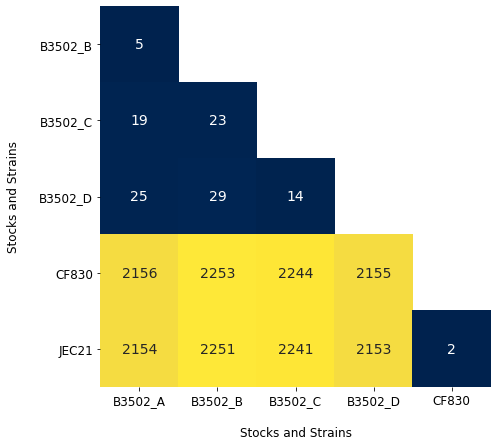

In [30]:
## Call figure
fig,ax = plt.subplots(1,1,figsize=(7,7))

## Plot heat map of counts adding mask
sns.heatmap(b3502_counts.T.replace(np.nan,-1),
            vmin = 0,cmap='cividis',cbar=False,
            mask=b3502_counts.T.isnull(),annot=True,
            fmt="d",annot_kws={"fontsize":14})

## fix tick lables
plt.yticks(rotation=0,fontsize=12);
plt.xticks(fontsize=12);

## Add x and y lables
plt.xlabel('\nStocks and Strains',fontsize=12)
plt.ylabel('Stocks and Strains\n',fontsize=12)

## Save figure
plt.savefig('../FIGURES/VARIANTS_B3502_Stocks_MAT.pdf',
            dpi=200,bbox_inches='tight');

In [31]:
variants[(variants[['JEC21','B3502_A1']].T.var()!=0)].groupby('Chromosome').count()

,index,Seqid,Pos,Qual,Nalleles,Alleles,Maxlen,Minlen,Type,Callrate,...,A30,A31,A33,A32,A34,Length,Cumlen,Midpts,Left,Right
Chromosome,,,,,,,,,,,,,,,,,,,,,
1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,467,467,467,467,467,467,467,467,467,467,...,467,467,467,467,467,467,467,467,467,467
3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,1291,1291,1291,1291,1291,1291,1291,1291,1291,1291,...,1291,1291,1291,1291,1291,1291,1291,1291,1291,1291
5,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
8,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
9,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [32]:
variants[variants[['JEC21','CF830']].T.var() != 0]

,index,Seqid,Pos,Qual,Nalleles,Alleles,Maxlen,Minlen,Type,Callrate,...,A31,A33,A32,A34,Length,Cumlen,Midpts,Chromosome,Left,Right
61960,21592,AE017346.1,739753,53384.9,1,C.T,1,1,SNP,1.0,...,0.0,0.0,0.0,0.0,1438917,9328782,10048240.5,6,869013,923874
93161,33769,AE017350.1,996827,89202.3,1,GAACT.GACT,5,4,del,1.0,...,0.0,0.0,1.0,0.0,1085720,14488368,15031228.0,10,807373,880180


In [33]:
b3502_JEC21

['B3502_A1', 'B3502_B1', 'B3502_C1', 'B3502_D1', 'CF830', 'JEC21']

In [34]:
private_allele_seg = np.array(progeny,dtype='object')[(variants[(variants[ancestors].T.var() == 0)][progeny].sum() > 0)]

In [35]:
sampled_progeny = sorted(list(np.random.choice([p for p in progeny if p not in private_allele_seg],12,replace=False)))

In [36]:
heatmap_progeny = ancestors[-2:] + b3502_JEC21 + sampled_progeny
len(heatmap_progeny)

20

In [37]:
plotvars = variants.reset_index(drop=True).copy()

In [38]:
plotvars[heatmap_progeny].drop_duplicates().shape

(44, 20)

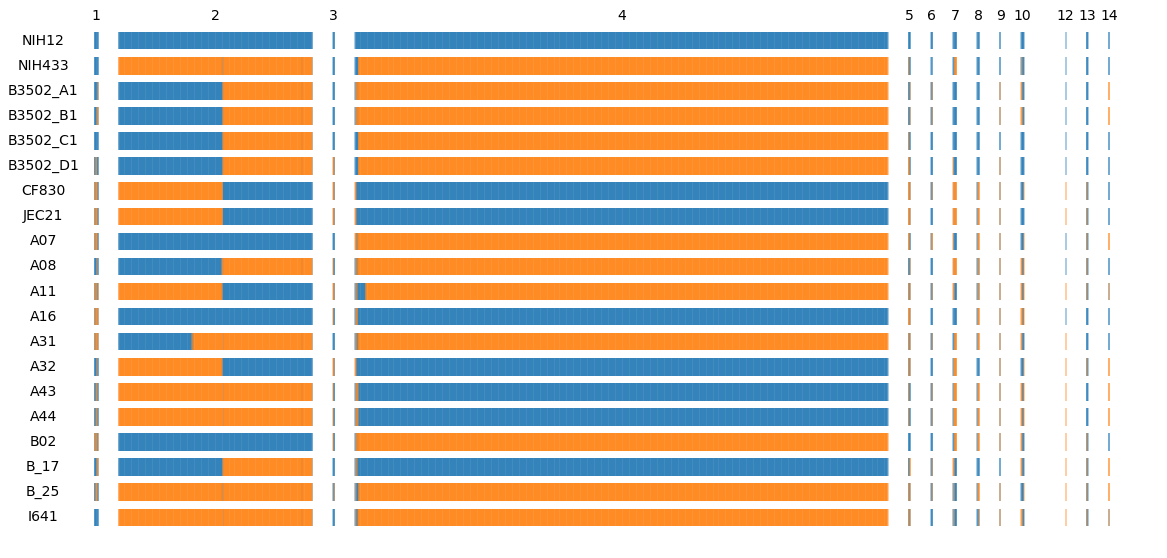

In [39]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
plot_colors = ['tab:blue','tab:orange']

plotspace = 50
plotvars['Space']  = (plotvars['Chromosome']*plotspace) - plotspace


normby = 'NIH12'
for i, s in enumerate(heatmap_progeny[::-1]):
    
    plotvars['temp'] = np.abs(plotvars[s] - plotvars[normby])
    #plotvars['temp'] = plotvars[s]
    
    for gt in [0,1]:
        
        xi = plotvars[(plotvars['temp']==gt)].index 
        x = plotvars.loc[xi,'Space'].values + xi.values
        y = np.ones(len(x))* i
        
        #plt.plot(x,y,color=plot_colors[gt],marker='s',alpha=0.5)
        plt.vlines(x,y-0.35,y+0.35,color=plot_colors[gt],alpha=0.5)
        
    plt.text(-2.5*plotspace,i,s,va='center',ha='center',fontsize=14)
    
for chrom in plotvars.Chromosome.unique():
    
    temp = plotvars[(plotvars.Chromosome==chrom)]
    
    x = np.mean(temp.index) + temp['Space'].mean()
    
    plt.text(x,len(heatmap_progeny),chrom,
             va='center',ha='center',fontsize=14)
    
plt.axis('off');
plt.savefig('../FIGURES/Variant_haplomap_B3502_bars_%s_normed.pdf'%normby,
            dpi=300,bbox_inches='tight');

In [40]:
heat_map_var = variants[heatmap_progeny+['Pos','Chromosome']]

newcolumns = []

for i in heat_map_var.columns:
    
    if i in ['Pos','Chromosome']:
        newcolumns.append(i)
        
    elif i.split('_')[0] == 'B3502':
        newcolumns.append('B3502_%s'%i.split('_')[-1][0])
    
    elif len(i.split('_')) == 2 and i.split('_')[0]!='B3502':
        newcolumns.append(''.join(i.split('_')))
    else:
        newcolumns.append(i)
        
heat_map_var.columns = newcolumns
heatmap_map_prog = newcolumns[:-2]

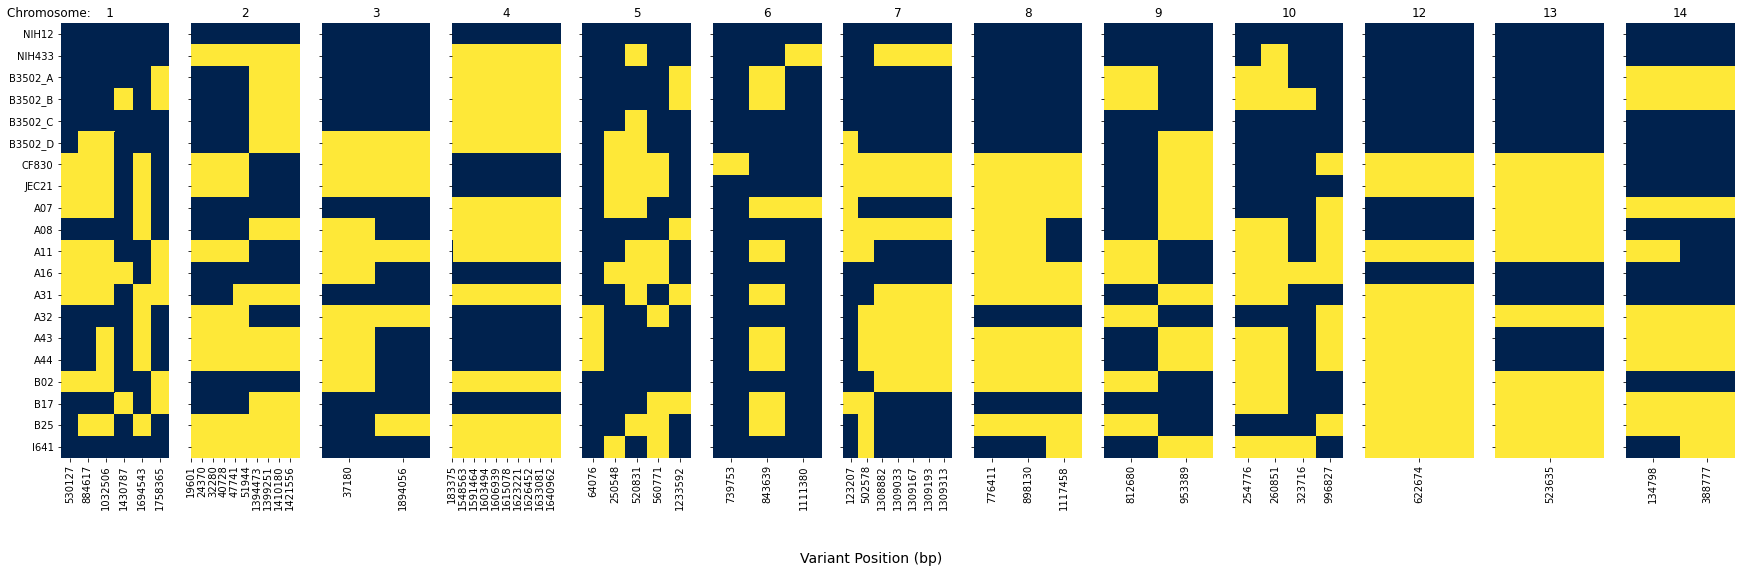

In [41]:
fig,ax = plt.subplots(1,13,figsize=(30,8),sharey=True)
fig.set_facecolor('w')

for i,ch in enumerate(sorted(variants.Chromosome.unique())):
    
    temp = qtlfun.findchrom(heat_map_var,ch,chrom='Chromosome').reset_index(drop=True).copy()
        
    temp.index = temp.Pos
    plt.sca(ax.ravel()[i])

    temp[heatmap_map_prog] = np.abs(temp[heatmap_map_prog].T - temp[normby]).T
    
    temp = temp[(temp[heatmap_map_prog].T.var()!=0)]
    sns.heatmap(temp[heatmap_map_prog].T,cmap='cividis',
                cbar=False,vmin=0,vmax=1);
    
    plt.xticks(rotation=90);
    plt.xlabel(' ')
    plt.title('Chromosome:    %s'%ch if i == 0 else '%s'%ch,
              x=0 if i == 0 else 0.5)

fig.text(0.5,-0.05,'Variant Position (bp)',va='center',ha='center',fontsize=14);
#plt.savefig('../FIGURES/Variant_haplomap_B3502_heat_%s_normed.pdf'%normby,
#            dpi=300,bbox_inches='tight')
plt.savefig('../FIGURES/Supplementary_Figure_S3.png',
            dpi=300,bbox_inches='tight');

In [42]:
variants['Chrom'] = variants.Chromosome

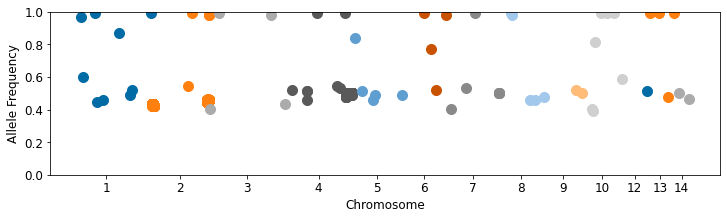

In [43]:
qtlfun.manhattan(variants,pval='MAF',marker='o',ms=10,ylims=(0,1),ylabel='Allele Frequency');

In [110]:
import snpy
variants = snpy.geneoverlap(variants,gff)

In [111]:
info_cols = [c for c in variants.columns if c not in samples+['Length','Cumlen','Midpts','Left','Right','Maxlen','Minlen','index','Chrom','B3502_C1_73']]

In [112]:
table_S5_col = info_cols + ancestors 
priv_col = info_cols + list(private_allele_seg)

In [113]:
Table_S5 = variants[(variants[ancestors].T.var() != 0)][table_S5_col]
Table_S5.to_csv("../GENOTYPE/Supplementary_Tabel_S5.csv",index=False)
Table_S5.head()

,Seqid,Pos,Qual,Nalleles,Alleles,Type,Callrate,MAF,Chromosome,Strand,...,B3502_B1,B3502_B7,B3502_C1,B3502_C1_37,B3502_D1,CF830,JEC20,JEC21,NIH12,NIH433
3300,AE017341.1,530127,124679.0,1,C.G,SNP,1.0,0.597826,1,-1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5447,AE017341.1,884617,106015.0,1,AGG.AGA,MNP,1.0,0.445652,1,-1,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6306,AE017341.1,1032506,140296.0,1,T.C,SNP,1.0,0.456522,1,-1,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
8729,AE017341.1,1430787,25794.6,1,G.T,SNP,1.0,0.869565,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10065,AE017341.1,1694543,159304.0,1,G.C,SNP,1.0,0.489130,1,1,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [114]:
private_vars =  variants[(variants[ancestors].T.var() == 0)][priv_col]
private_vars.to_csv("../GENOTYPE/F1_denovo_mutations.csv",index=False)
private_vars.head()

,Seqid,Pos,Qual,Nalleles,Alleles,Type,Callrate,MAF,Chromosome,Strand,...,A40,B01,B04,B_19,B_22,B_23,B_27,B_28,B_32,B_33
2982,AE017341.1,474535,7741.500,1,G.C,SNP,1.0,0.967391,1,-1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5112,AE017341.1,835830,2229.390,1,C.A,SNP,1.0,0.989130,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13358,AE017341.1,2235752,980.044,1,CTA.CTTA,ins,1.0,0.989130,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19723,AE017342.1,1019660,846.269,1,G.A,SNP,1.0,0.989130,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22004,AE017342.1,1428283,4946.500,1,G.T,SNP,1.0,0.978261,2,-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
checks = []
for si,s in enumerate(private_allele_seg):
    tempgt = private_vars[(private_vars[s]!=0)]
    
    for ri,r in tempgt.iterrows():
        tempdp = depth[(depth.Seqid==r.Seqid) & (depth.Pos==r.Pos)][s].min()
        tempad = allelr[(allelr.Seqid==r.Seqid) & (allelr.Pos==r.Pos)][s].min()
        
        allels = r.Alleles.split('.')
        
        if len(allels) > 2:
            print("More than two alleles: %s!"%r.Alleles)

        checks.append((s,r.Seqid,r.Chromosome,r.Pos,tempdp,tempad,allels[0],allels[1],r.Gene,r.Description))
        
checks = pd.DataFrame(checks)
checks.columns = ['Strain','Seqid','Chromosome','Position','Depth','Ratio','Ref','Alt','Gene','Description']
checks.sort_values(['Chromosome','Position'],inplace=True)

In [148]:
variants[(variants.Chromosome==2) & (variants.Pos==1428226)][info_cols]

,Seqid,Pos,Qual,Nalleles,Alleles,Type,Callrate,MAF,Chromosome,Strand,Gene,Description
22003,AE017342.1,1428226,138072.0,1,A.G,SNP,1.0,0.456522,2,-1,CNB05000,conserved hypothetical protein


In [149]:
len('TTCTGACAACAGTCCGTCATCATCCAATAAT')

31

samtools view -b SS_20201123_A01_S17_L001-sm-rg.bam AE017342.1:1420000-1440000 > ../chr2.1428283.A01.bam

samtools view -b SS_20201123_A04_S20_L001-sm-rg.bam AE017342.1:1420000-1440000 > ../chr2.1428283.A04.bam

samtools view -b SS_20201123_A39_S55_L001-sm-rg.bam AE017342.1:1420000-1440000 > ../chr2.1428283.A39.bam



samtools view -b SS_20201123_A39_S55_L001-sm-rg.bam AE017343.1:1520000-1540000 > ../chr3.1534147.A39.bam

samtools view -b SS_20201123_A39_S55_L001-sm-rg.bam AE017350.1:600000-620000 > ../chr10.615633.A39.bam

samtools view -b SS_20201123_A39_S55_L001-sm-rg.bam AE017353.1:650000-670000 > ../chr13.663313.A39.bam


samtools view -b 6975-S23_S-smr.bam AE017341.1:460000-480000 > ../chr1.474535.B22.bam

samtools view -b 6975-S24_S-smr.bam AE017341.1:460000-480000 > ../chr1.474535.B23.bam

samtools view -b 6975-S29_S-smr.bam AE017341.1:460000-480000 > ../chr1.474535.B28.bam

In [155]:
checks

,Strain,Seqid,Chromosome,Position,Depth,Ratio,Ref,Alt,Gene,Description
20,B_22,AE017341.1,1,474535,78.0,0.99,G,C,CNA01770,endoplasmic reticulum protein putative
21,B_23,AE017341.1,1,474535,97.0,1.00,G,C,CNA01770,endoplasmic reticulum protein putative
23,B_28,AE017341.1,1,474535,66.0,1.00,G,C,CNA01770,endoplasmic reticulum protein putative
4,A19,AE017341.1,1,835830,78.0,1.00,C,A,CNA03160,heat shock protein sks2 (heat shock cognate pr...
5,A19,AE017341.1,1,2235752,35.0,1.00,CTA,CTTA,NaN,NaN
7,A21,AE017342.1,2,1019660,32.0,1.00,G,A,CNB03390,nucleus protein putative
0,A01,AE017342.1,2,1428283,93.0,1.00,G,T,CNB05000,conserved hypothetical protein
2,A04,AE017342.1,2,1428283,65.0,1.00,G,T,CNB05000,conserved hypothetical protein
1,A01,AE017342.1,2,1432809,51.0,1.00,TTCTGACAACAGTCCGTCATCATCCAATAAT,TT,NaN,NaN
3,A04,AE017342.1,2,1432809,36.0,1.00,TTCTGACAACAGTCCGTCATCATCCAATAAT,TT,NaN,NaN


In [51]:
NIHs = ancestors[-2:]

In [53]:
genotype[(genotype[NIHs].diff(axis=1)[NIHs[-1]]!=0) & 
         (depth[NIHs].T.min()>=cov_x) & 
         (allelr[NIHs].T.min()>=allele_ratio) & 
         ~(genotype.index.isin(centdropix))][NIHs].dropna().shape[0]

104153

In [54]:
ancestor_strains = NIHs + b3502_JEC21[:-2] + ['JEC20','JEC21','CF830']
len(ancestor_strains)

9

In [55]:
progenitor_gt = genotype[(genotype[ancestor_strains].T.var() > 0) & 
                         (depth[ancestor_strains].T.min()>=cov_x) & 
                         (allelr[ancestor_strains].T.min()>=allele_ratio) & 
                         ~(genotype.index.isin(centdropix))].dropna()

In [56]:
## Set variables for plotting
plotspace = 500000
progenitor_gt['Space']  = (progenitor_gt['Chromosome']*plotspace) - plotspace
ymod = 0.3
xmod = 2.5

In [57]:
## Set relative regions of MAT locus
MAT = np.array([1529240,1661861])
cumMAT = MAT + progenitor_gt[(progenitor_gt.Chromosome==4)][['Cumlen','Space']].drop_duplicates().T.sum().min() 

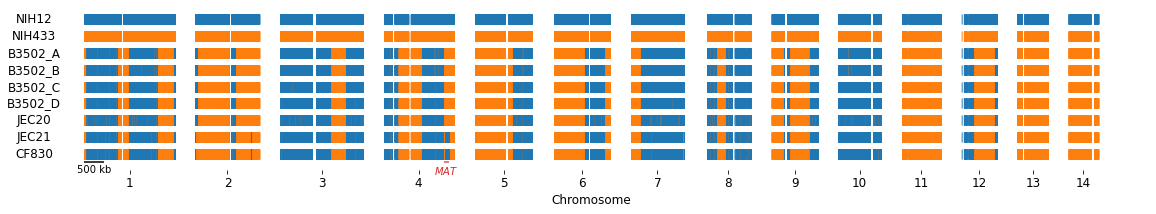

In [58]:
## Call figure and set face color
fig,ax = plt.subplots(1,1,figsize=(20,3))
fig.set_facecolor('w')

## Set strain to rephase by
normby = 'NIH12'

## Iterate over strains
for si, s in enumerate(ancestor_strains[::-1]):
    
    ## Rephase by strain
    progenitor_gt['temp'] = np.abs(progenitor_gt[s] - progenitor_gt[normby])
    
    ## Iterate over genotype
    for gt in [0,1]:
        
        ## Gather loci based on genotype
        xi = progenitor_gt[(progenitor_gt['temp']==gt)].index 
        x = progenitor_gt.loc[xi,['Space','Pos','Cumlen']].T.sum().values
        y = np.ones(len(xi))* si
        
        ## Plot chromosome
        plt.vlines(x,y-ymod,y+ymod,color=plot_colors[gt],alpha=0.35,rasterized = True,linewidth=0.5)   
        
    ## Add strain name
    plt.text(-xmod*plotspace,si,s if s[:3]!='B35' else s[:-1],va='center',ha='center',fontsize=12)
       
## Add mat locus
plt.hlines(-0.5,*cumMAT,color='tab:red',alpha=0.8)
plt.text(np.mean(cumMAT),-0.6,s='$MAT$',fontsize=10,va='top',ha='center',color='tab:red')

## Add scale bar
chrom1posmin = progenitor_gt[(progenitor_gt.Chromosome==1)].Pos.min()
bar_kb = 500
scale_bar = (chrom1posmin,chrom1posmin + bar_kb*1000)
plt.hlines(-0.5,*scale_bar,color='k')
plt.text(np.mean(scale_bar),-0.6,s='%s kb'%bar_kb,fontsize=10,va='top',ha='center')

## turn off spines
[ax.spines[t].set_visible(False) for t in ['top','right','left','bottom']]

## Turn off yticks
plt.yticks([],[])

## Set xticks and x-label      
plt.xticks(progenitor_gt.Midpts.unique()+progenitor_gt.Space.unique(),np.arange(1,15),fontsize=12)
plt.xlabel('Chromosome',fontsize=12);

## save figure
plt.savefig('../FIGURES/Progenitor_haplotypes_B3502_%s_normed.pdf'%normby,
            dpi=300,bbox_inches='tight')

In [59]:
progenitor_gt.groupby(['Nalleles']).count()

,index,Seqid,Pos,Qual,Alleles,Maxlen,Minlen,Type,Callrate,MAF,...,A32,A34,Length,Cumlen,Midpts,Chromosome,Left,Right,Space,temp
Nalleles,,,,,,,,,,,,,,,,,,,,,
1,103435,103435,103435,103435,103435,103435,103435,103435,103435,103435,...,103435,103435,103435,103435,103435,103435,103435,103435,103435,103435
2,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
3,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
